# Проект: классификация

In [651]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [652]:
df = pd.read_csv('bank_fin.zip', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [653]:
# Пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [654]:
df['job'].unique()
# Пропуски в таблие записаны как unknown

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [655]:
# Убираем знак $ из balance
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [656]:
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()

1526.9360329690019

### Задание 5

In [657]:

df['job'] = df['job'].replace(np.nan, df['job'].mode()[0])
df['education'] = df['education'].replace(np.nan, df['education'].mode()[0])
df_5 = df[(df['education'] == df['education'].mode()[0]) & (df['job'] == df['job'].mode()[0])]
df_5['balance'].mean()

1353.6134453781513

### Задание 6

In [658]:
# Находим квантили
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)

# Вычисление IQR
IQR = Q3 - Q1

# Определение нижней и верхней границ по методу Тьюки
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

df.shape 

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

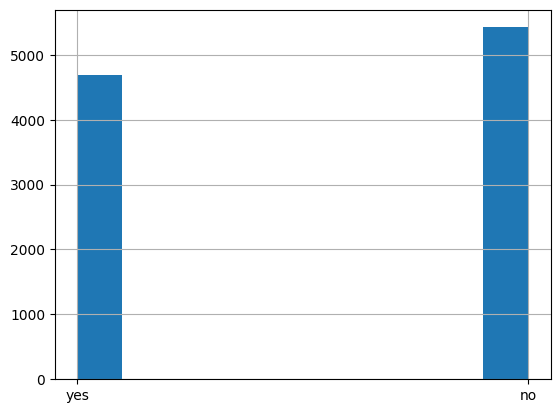

In [659]:
df.deposit.hist()
df.deposit.value_counts()

### Задания 2 и 3

In [660]:
df.age.max()
df.duration.min()

2

### Задания 4 и 5

In [661]:
df.job.unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 6

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


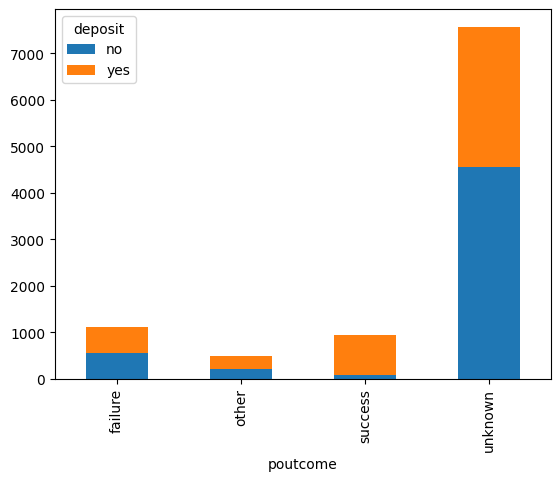

In [662]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')
types

### Задание 7

In [663]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
for i in np.unique(df.month):
    print(i, df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


### Задание 8

30-40 0.4234773555439875
40-50 0.3968957871396896
50-60 0.4258461538461538
60+ 0.8109161793372319
<30 0.5620320855614973


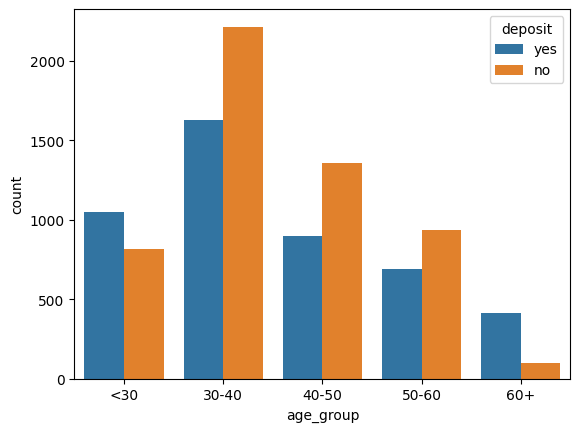

In [664]:
# создайте возрастные группы и определите, 
# в каких группах более склонны открывать депозит, 
# чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)
import seaborn as sns
import matplotlib.pyplot as plt

# Подсчет количества значений в каждой категории "group"

for i in np.unique(df.age_group):
    print(i, df[(df.age_group == i)&(df.deposit == 'yes')].shape[0]/df[(df.age_group == i)].shape[0])


### Задания 9 и 10

age                                                        \
marital   divorced                            married                      
education  primary secondary tertiary unknown primary secondary tertiary   
deposit                                                                    
no              91       347      163      23     641      1693      832   
yes             96       265      174      18     339      1169      784   

                                     ... previous                            \
marital            single            ... divorced         married             
education unknown primary secondary  ... tertiary unknown primary secondary   
deposit                              ...                                      
no            137     100       799  ...      163      23     641      1693   
yes           120      82       805  ...      174      18     339      1169   

                                                               
marital                     single                             
education tertiary unknown primary secondary tertiary unknown  
deposit                                                        
no             832     137     100       799      531      67  
yes            784     120      82       805      755      74  

[2 rows x 180 columns]

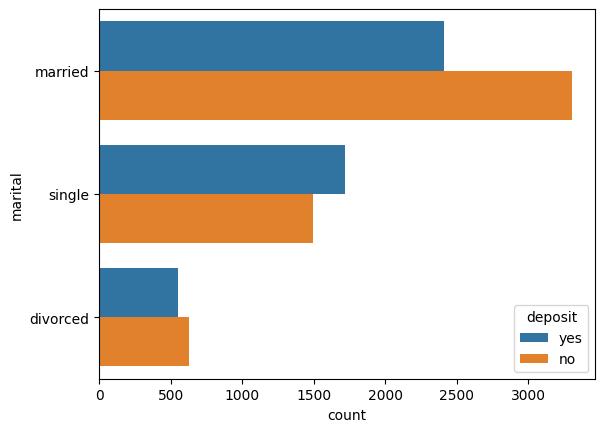

In [665]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

df.job.value_counts()

df_m = df.pivot_table(columns= ['marital', 'education'], index = 'deposit', aggfunc='count')
sns.countplot(y='marital', hue='deposit', data=df)
df_m

### Задание 11

In [666]:
# постройте сводную таблицу, 
# чтобы определить люди с каким образованием 
# и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_11 = df[df.deposit == 'yes']
df_11 = df_11.groupby(['marital', 'education'])

## Часть 3: преобразование данных

### Задание 1

In [667]:
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])
df['age_group'] = lab_enc.fit_transform(df['age_group'])
df['education'].sum()

12873

### Задания 2 и 3

In [668]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['deposit'].std()

df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan']= df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
print(df['default'].mean() + df['housing'].mean() + df['loan'].mean())
df['default'].mean()

0.6354280059376547


0.016427511133102424

### Задание 4

In [669]:
# создайте дамми-переменные
dummies = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome', 'default', 'housing']])

# Объединение с исходным DataFrame
df = pd.concat([df, dummies], axis=1)
print(len(list(df.columns)))

54


### Задания 5 и 6

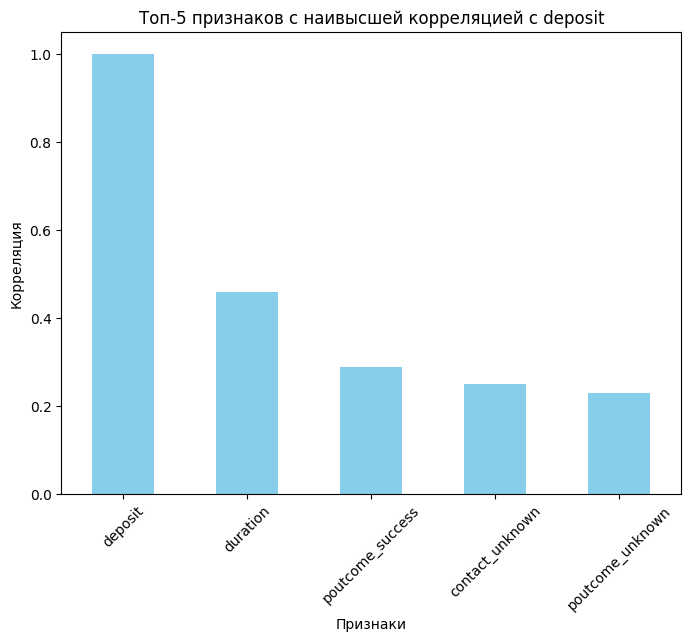

In [670]:
target_feature = 'deposit'

correlation_matrix = df.corr()

# Извлеките корреляции между выбранным признаком и другими признаками
correlation_with_target = correlation_matrix[target_feature]

# Сортируйте корреляции по убыванию
sorted_correlation = correlation_with_target.abs().sort_values(ascending=False)

# Выберите только пять главных признаков (включая целевой признак)
top_features = sorted_correlation.head(5)

# Постройте столбчатую диаграмму только для выбранных признаков
plt.figure(figsize=(8, 6))
top_features.plot(kind='bar', color='skyblue')
plt.xlabel('Признаки')
plt.ylabel('Корреляция')
plt.title(f'Топ-5 признаков с наивысшей корреляцией с {target_feature}')
plt.xticks(rotation=45)
plt.show()

Пары признаков с наибольшей корреляцией (больше 0.9):
poutcome_failure  pdays               0.608719
pdays             poutcome_failure    0.608719
age               job_retired         0.545524
job_retired       age                 0.545524
pdays             previous            0.513708
previous          pdays               0.513708
dtype: float64


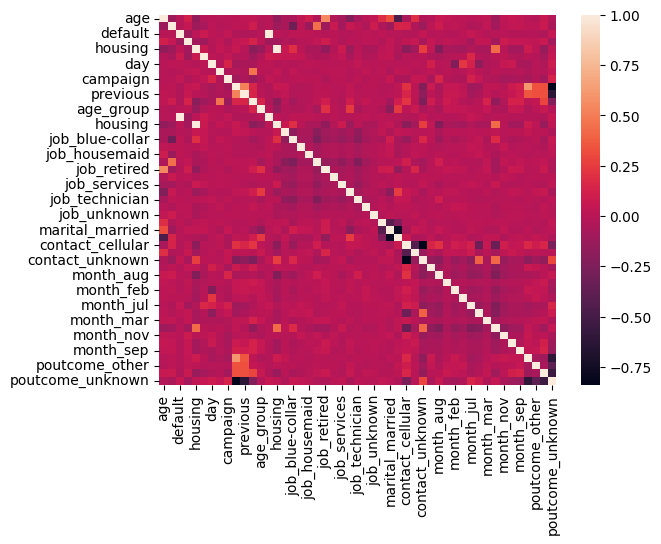

In [671]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(df.corr())
corr_matrix = df.corr()

correlation_matrix = df.corr()

# Используйте метод unstack(), чтобы преобразовать матрицу корреляции в Seri
correlation_series = correlation_matrix.unstack()

# Отсортируйте значения корреляции по убыванию
sorted_correlation = correlation_series.sort_values(ascending=False)

# Уберите значения корреляции с единицей (корреляция признака с самим собой)
sorted_correlation = sorted_correlation[sorted_correlation != 1]

# Выберите пары признаков с наибольшей корреляцией (больше 0.9)
high_correlation_pairs = sorted_correlation[sorted_correlation > 0.5]

print("Пары признаков с наибольшей корреляцией (больше 0.9):")
print(high_correlation_pairs)

### Задания 7 и 8

In [672]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [673]:
y_test.mean()

0.46326836581709147

### Задание 9

In [674]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Загрузите ваш DataFrame с признаками и целевой переменной
# df = pd.read_csv('your_data.csv')

# Оставьте только числовые признаки
numerical_features = df.select_dtypes(include=['number'])

# Разделите данные на обучающий и тестовый наборы, если необходимо

# Определите количество признаков, которые нужно отобрать (в данном случае, 15)
k = 15

# Инициализируйте SelectKBest с score_func = f_classif
selector = SelectKBest(score_func=f_classif, k=k)

# Примените SelectKBest к данным
X_new = selector.fit_transform(numerical_features, y)  # y - ваша целевая переменная

# Получите индексы отобранных признаков
selected_feature_indices = selector.get_support(indices=True)

# Выберите только отобранные признаки из исходного DataFrame
features_list = numerical_features.iloc[:, selected_feature_indices]

# Теперь selected_features содержит только 15 наилучших признаков


display(features_list)

,balance,housing,duration,campaign,pdays,previous,deposit,age_group,housing,contact_cellular,contact_unknown,month_mar,month_may,poutcome_success,poutcome_unknown
0,2343.0,1,1042,1,-1,0,1,2,1,0,1,0,1,0,1
1,45.0,0,1467,1,-1,0,1,2,0,0,1,0,1,0,1
2,1270.0,1,1389,1,-1,0,1,1,1,0,1,0,1,0,1
3,2476.0,1,579,1,-1,0,1,2,1,0,1,0,1,0,1
4,184.0,0,673,2,-1,0,1,2,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1.0,1,257,1,-1,0,0,0,1,1,0,0,0,0,1
11158,733.0,0,83,4,-1,0,0,0,0,0,1,0,0,0,1
11159,29.0,0,156,2,-1,0,0,0,0,1,0,0,0,0,1
11160,0.0,0,9,2,172,5,0,1,0,1,0,0,1,0,0


In [675]:
print(list(df.columns))

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'age_group', 'default', 'housing', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [676]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

X_train = X_train[['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']]
X_test = X_test[['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']]

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.46823674223097866


In [677]:
display(X_test)

,balance,housing,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
3333,155.0,0,0,290,1,93,2,3,0,0,1,0,0,0,1,0
6048,512.0,0,0,70,1,-1,0,2,1,0,0,0,0,0,0,1
5675,1403.0,0,0,214,8,326,2,0,1,0,0,1,0,0,0,0
2564,1270.0,0,0,232,3,-1,0,0,1,0,0,0,0,0,0,1
8983,1074.0,1,1,523,2,-1,0,2,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,507.0,0,0,380,1,-1,0,4,1,0,0,0,0,0,0,1
9672,443.0,0,0,10,1,2,1,0,1,0,0,0,0,0,0,0
8584,-311.0,1,1,55,2,345,2,0,1,0,0,1,0,0,0,0
10972,250.0,0,0,133,1,-1,0,4,1,0,0,0,0,0,0,1


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [687]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

print(metrics.accuracy_score(y_test, y_pred))

0.808095952023988


### Задания 2,3,4

In [700]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)


print(metrics.classification_report(y_train_pred, y_train))
print(metrics.classification_report(y_test_pred, y_test))


              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3312
           1       0.86      0.78      0.81      3458

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1629
           1       0.84      0.76      0.80      1706

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [701]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 
               'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, 
                        scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(model_cv.score(X_test_scaled, y_test)))
y_test_pred = model_cv.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [702]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
y_test_pred = model_cv.predict(X_test_scaled)
print(metrics.classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1737
           1       0.82      0.79      0.80      1598

    accuracy                           0.81      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



### Задания 2 и 3

In [703]:
# используйте для классификации градиентный бустинг 
# и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1731
           1       0.83      0.80      0.82      1604

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [704]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)
y_test_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1785
           1       0.81      0.81      0.81      1550

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

Text(0.5, 1.0, 'График влияния признаков на Кредитный рейтинг')

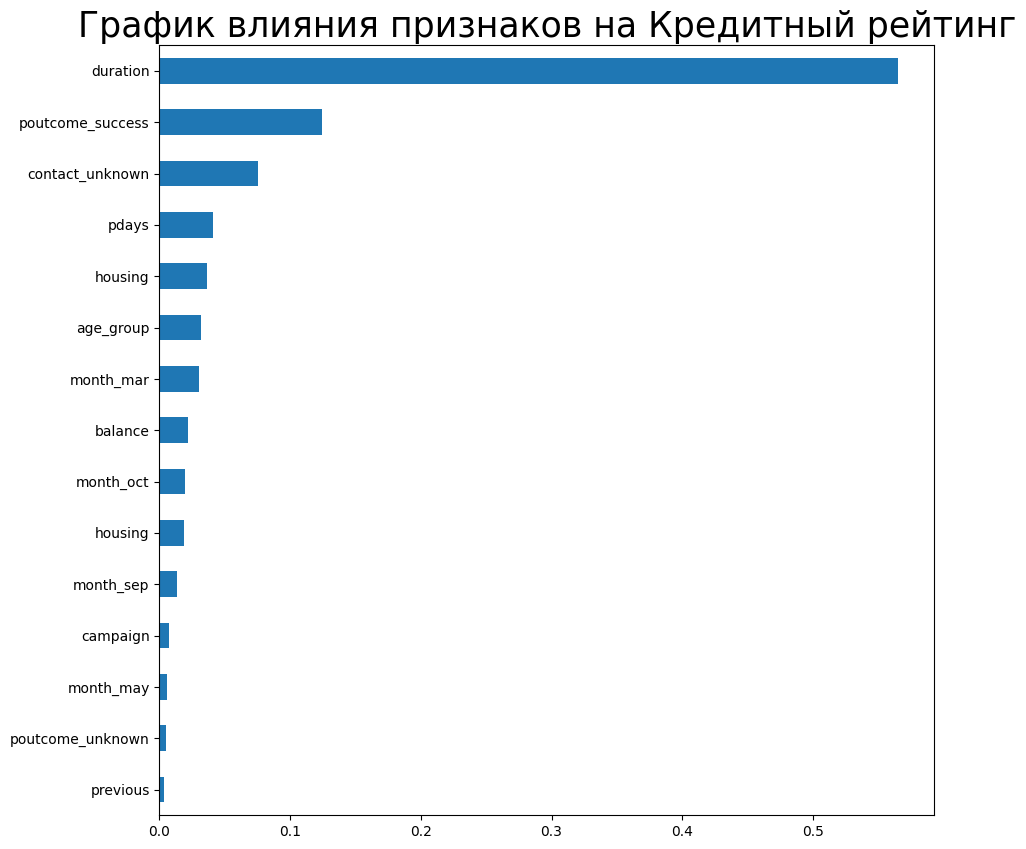

In [713]:
gb = ensemble.GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh')
plt.title("График влияния признаков на Кредитный рейтинг", fontsize=25)

In [714]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [717]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-10-04 08:10:16,269] A new study created in memory with name: RandomForestClassifier
[I 2023-10-04 08:10:17,711] Trial 0 finished with value: 0.815165876777251 and parameters: {'n_estimators': 173, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.815165876777251.
[I 2023-10-04 08:10:19,426] Trial 1 finished with value: 0.8176100628930818 and parameters: {'n_estimators': 181, 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8176100628930818.
[I 2023-10-04 08:10:21,639] Trial 2 finished with value: 0.8171230720805791 and parameters: {'n_estimators': 188, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8176100628930818.
[I 2023-10-04 08:10:22,979] Trial 3 finished with value: 0.8135058378037237 and parameters: {'n_estimators': 152, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8176100628930818.
[I 2023-10-04 08:10:24,406] Trial 4 finished with value: 0.8158890290037831 and parameters: {'n_e

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 18, 'min_samples_leaf': 7}
f1_score на обучающем наборе: 0.82


In [718]:
print(metrics.classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1785
           1       0.81      0.81      0.81      1550

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

